In [1]:
import numpy as np
import pandas as pd 
import sqlite3 as sql
import matplotlib.pyplot as plt
%matplotlib inline  
import scipy.stats as stats
import seaborn as sns
sns.set_theme(style="darkgrid")

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import time
start_time = time.time()

conn = sql.connect('databases/frequentation_dtwh.db')
cursor = conn.cursor()

SQL_Query = pd.read_sql_query(
    '''select 
Frequentation_quotidienne.date, 
Frequentation_quotidienne.prevision, 
Frequentation_quotidienne.reel,
Dim_site.*,
Dim_menu.plats,
Dim_temporelle.vacances_dans, 
Dim_temporelle.depuis_vacances,
Dim_temporelle.ferie_dans, 
Dim_temporelle.depuis_ferie, 
Dim_temporelle.chretiennes_dans,
Dim_temporelle.depuis_chretiennes,
Dim_temporelle.juives_dans,
Dim_temporelle.depuis_juives, 
Dim_temporelle.ramadan_dans, 
Dim_temporelle.depuis_ramadan, 
Dim_temporelle.musulmanes_dans, 
Dim_temporelle.depuis_musulmanes,
Dim_evenement.chretiennes, 
Dim_evenement.juives,
Dim_evenement.ramadan, 
Dim_evenement.musulmanes, 
Dim_evenement.greve

from Frequentation_quotidienne

left join Dim_site               on Frequentation_quotidienne.site_id = Dim_site.site_id
left join Dim_menu               on Frequentation_quotidienne.jour_id = Dim_menu.jour_id
left join Dim_temporelle         on Frequentation_quotidienne.jour_id = Dim_temporelle.jour_id
left join Dim_evenement          on Frequentation_quotidienne.jour_id = Dim_evenement.jour_id

order by Frequentation_quotidienne.jour_site_id
''', conn)

data = pd.DataFrame(SQL_Query, columns=['date', 'prevision', 'reel', 'site_type', 'cantine_nom',
                                        'annee_scolaire', 'effectif', 'quartier_detail',
                                        'prix_quartier_detail_m2_appart', 'prix_moyen_m2_appartement',
                                        'prix_moyen_m2_maison', 'longitude', 'latitude',
                                        'plats',
                                        'vacances_dans', 'depuis_vacances',
                                        'ferie_dans', 'depuis_ferie', 'chretiennes_dans', 'depuis_chretiennes',
                                        'juives_dans', 'depuis_juives', 'ramadan_dans', 'depuis_ramadan',
                                        'musulmanes_dans', 'depuis_musulmanes',
                                        'chretiennes', 'juives',
                                        'ramadan', 'musulmanes', 'greve'])

print("--- %s seconds ---" % (time.time() - start_time))

--- 1.323845624923706 seconds ---


In [3]:
data.to_csv('../data/data.csv', index=False)

## Transformation de la cible

### Transformation avec la racine carrée

En application des conclusions de l'analyse exploratoire.

In [4]:
data['reel'] = data['reel']**(1/2)

### Gestion des outliers dans la cible

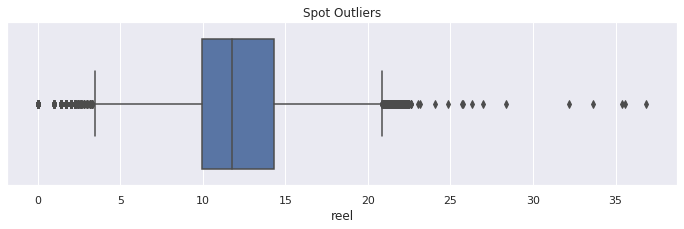

In [5]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Spot Outliers')
sns.boxplot(x='reel', data=data);

Après une inspection approfondie de l'ensemble de données, la plupart des valeurs aberrantes semblent apparaître proches d'événements de grève ou simplement dues à une erreur humaine. La plupart de ses événements se sont produit avec un court préavis, c'est-à-dire que nous n'aurons pas cette information au moment de la prédiction (2-3 semaines avant).

En un mot, ils ne sont pas significatifs de la distribution des données, ils n'ont pas de sens particulier.

In [6]:
def zscore_outliers(data, column, n):
    """
    Tag outliers in dataset in regard from a specific column
    In literature, often 3 std from the mean is consider as an outlier
    Return two boolean columns : upper_outlier and lower_outlier
    """

    outliers = data[(data[column] != 0)]

    # we aggregate value by cantine and année in order to have
    # a meaningfull outlier detection system and compare what's comparable
    outliers = outliers.groupby(["cantine_nom", "annee_scolaire"])
    outliers = outliers[column].agg(["mean", "std"])

    outliers['lower_bound'] = outliers['mean'] - (n * outliers['std'])
    outliers['upper_bound'] = outliers['mean'] + (n * outliers['std'])

    data = data.merge(outliers, left_on=[
                      "cantine_nom", "annee_scolaire"], right_index=True, how='left')

    data["upper_outlier"] = data[column] > data['upper_bound']
    data["lower_outlier"] = data[column] < data['lower_bound']

    data.drop(['upper_bound', 'lower_bound',"mean", "std"], axis=1, inplace=True)

    return data

data = zscore_outliers(data, 'reel', 3)

In [7]:
print(data[data['upper_outlier']==True].shape)
print(data[data['lower_outlier']==True].shape)

(66, 33)
(2057, 33)


In [8]:
data.shape

(91082, 33)

In [9]:
# removing obvious outliers that would mistake the model
# most of the zeros are due to mistakes and not to really meaningful values
# strikes are not predictible by nature

data = data.loc[(data['greve'] != 1) & (data['reel'] != 0) & (data['upper_outlier'] != 1) & (data['lower_outlier'] != 1)]
data.shape

(82112, 33)

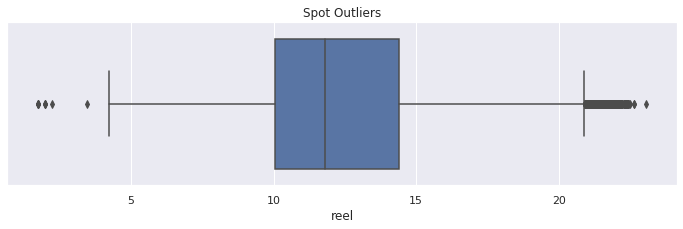

In [10]:
fig, ax = plt.subplots(figsize=(12, 3))
ax.set_title('Spot Outliers')
sns.boxplot(x='reel', data=data)

## Generation de features dérivées de la date

In [11]:
data["date"] = pd.to_datetime(data["date"])
data['year']=data['date'].dt.year 
data['month']=data['date'].dt.month 
data['day']=data['date'].dt.day
data['day_of_week']=data['date'].dt.dayofweek  
data['day_of_year'] = data.date.dt.dayofyear
data['quarter'] = data.date.dt.quarter
data['is_month_start'] = data.date.dt.is_month_start*1
data['is_month_end'] = data.date.dt.is_month_end*1
data['week'] = data.date.dt.isocalendar().week
data['week_of_month'] = data['date'].apply(lambda d: (d.day-1) // 7 + 1)

En général, les algorithmes peuvent être trompés par ce type de caractéristiques de date et d'heure. En fait, disons que nous codons lundi avec 0 et dimanche avec 6. 
Cette différence d'échelle ne signifie pas que le dimanche soit plus important que le lundi, cependant c'est ce que le modèle peut être ammener à comprendre.

Une méthode courante pour coder les données cycliques consiste à transformer les données en deux dimensions à l'aide d'une transformation en sinus et en cosinus (http://blog.davidkaleko.com/feature-engineering-cyclical-features.html). 

Il est important de coder les caractéristiques correctement pour l'algorithme d'apprentissage automatique spécifique utilisé. D'autres algorithmes d'apprentissage automatique peuvent être robustes vis-à-vis des caractéristiques cycliques brutes, notamment les approches basées sur les arbres. Cependant, les réseaux neuronaux profonds ont tout à gagner de la stratégie d'encodage décrite ci-dessus, notamment en termes de vitesse de convergence du réseau.

Ici, puisque nous voulons essayer plusieurs types d'algorithmes d'apprentissage, nous utiliserons cet encodage.

In [12]:
def encode_datetime_features(data, col):
    data[col + '_sin'] = np.sin(2 * np.pi * data[col]/max(data[col]))
    data[col + '_cos'] = np.cos(2 * np.pi * data[col]/max(data[col]))
    return data

for col in ['month', 'day', 'day_of_week', 'day_of_year', 'quarter', 'week', 'week_of_month']:
    encode_datetime_features(data, col)
    data.drop([col], axis=1, inplace=True)
    
# we keep the week feature as it is (in addition to sin/cos transformation)
# as we will need it later on
data['week'] = data.date.dt.isocalendar().week

In [13]:
data.loc[data['date']=='2018-09-03']

,date,prevision,reel,site_type,cantine_nom,annee_scolaire,effectif,quartier_detail,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,plats,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve,upper_outlier,lower_outlier,year,is_month_start,is_month_end,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,quarter_sin,quarter_cos,week_sin,week_cos,week_of_month_sin,week_of_month_cos,week
75602,2018-09-03,126.0,10.535654,E,JEAN JAURES,2012-2013,121,Centre ville,4200.0,4363.0,5869.0,1.5596,47.2194,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75603,2018-09-03,238.0,15.427249,M/E,FELLONNEAU,2013-2014,269,Hauts Pavés - Saint Félix,4131.0,3944.0,5138.0,1.5546,47.2316,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75604,2018-09-03,137.0,11.224972,M/E,ANDRE LERMITE/LAMORICIERE,2018-2019,377,None,NaN,NaN,NaN,NaN,NaN,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75605,2018-09-03,292.0,14.730920,M/E,FELLONNEAU,2016-2017,241,Hauts Pavés - Saint Félix,4131.0,3944.0,5138.0,1.5546,47.2316,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75606,2018-09-03,280.0,14.035669,E,ANATOLE DE MONZIE,2017-2018,155,Ile de Nantes,3207.0,3089.0,4189.0,1.5418,47.2029,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75607,2018-09-03,280.0,16.792856,M/E,RUE NOIRE,2017-2018,192,Hauts Pavés - Saint Félix,4131.0,4380.0,5080.0,1.5635,47.2248,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75608,2018-09-03,109.0,10.630146,E,BOCCAGE E,2016-2017,161,Hauts Pavés - Saint Félix,4131.0,4575.0,5443.0,1.5708,47.2155,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75609,2018-09-03,95.0,10.295630,M,JEAN ZAY M,2019-2020,261,None,NaN,NaN,NaN,NaN,NaN,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75610,2018-09-03,280.0,16.340135,M,FREDUREAU,2017-2018,80,Hauts Pavés - Saint Félix,4131.0,4093.0,4890.0,1.5611,47.2210,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36
75611,2018-09-03,140.0,11.789826,M,MAISDON PAJOT,2017-2018,203,Zola,3424.0,3553.0,4490.0,1.5848,47.2155,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,

## Ajout avec précaution de variables statistiques

C'est variables sont très sujettes à ce que l'on nomme le data leakage : de l'information du test set se propage dans le train set et conduit le modèle à des prédictions trop optimistes.

Afin d'éviter celà, il faut calculer la statistique sur le train set et l'imputer au train et au test set par la suite.

In [16]:
def add_statistical_features(data):

    train = data[(data["annee_scolaire"] != "2018-2019") &
                 (data["annee_scolaire"] != "2019-2020")]

    # to avoid data leakage we compute the relevant statistics on train set only
    train["freq_predicted_%"] = train["prevision"] / train["effectif"]
    train["freq_reel_%"] = train["reel"] / train["effectif"]

    # aggregate data significantly (canteen, year and week level) and compute statistics
    grouped_train = train.groupby(["cantine_nom", "week", "annee_scolaire"])
    grouped_train_m = grouped_train['freq_predicted_%',
                                    'freq_reel_%', 'prevision', 'reel'].mean().reset_index()
    grouped_train_s = grouped_train['freq_predicted_%',
                                    'freq_reel_%', 'prevision', 'reel'].std().reset_index()

    # then we average on the years, to have a single number per canteen and week
    # and thus being able to spread it to the test set
    agg_mean = grouped_train_m.groupby(["cantine_nom", "week"])
    agg_mean = agg_mean['freq_predicted_%', 'freq_reel_%'].mean()
    agg_std = grouped_train_s.groupby(["cantine_nom", "week"])
    agg_std = agg_std['freq_predicted_%', 'freq_reel_%'].mean()
    agg_std.rename(columns={'freq_predicted_%': 'freq_predicted_%_std',
                   'freq_reel_%': 'freq_reel_%_std'}, inplace=True)

    data = data.merge(
        agg_mean,
        left_on=["cantine_nom", "week"],
        right_index=True,
        how='left')

    data = data.merge(
        agg_std,
        left_on=["cantine_nom", "week"],
        right_index=True,
        how='left')

    return data

In [17]:
data = add_statistical_features(data)
data.head()

/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  del sys.path[0]
/home/quentin/.local/lib/python3.6/site-pa

,date,prevision,reel,site_type,cantine_nom,annee_scolaire,effectif,quartier_detail,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,plats,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve,upper_outlier,lower_outlier,year,is_month_start,is_month_end,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,quarter_sin,quarter_cos,week_sin,week_cos,week_of_month_sin,week_of_month_cos,week,freq_predicted_%,freq_reel_%,freq_predicted_%_std,freq_reel_%_std
0,2011-01-03,210.0,13.490738,M/E,FRANCOISE DOLTO,2010-2011,191,Nantes Nord,3143.0,3208.0,3333.0,1.5795,47.2652,hachis parmentier pamplemousse salade verte fl...,54,0,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,0.700127,0.056560,0.011723,0.001231
1,2011-01-03,100.0,9.643651,E,CHENE D'ARON E,2015-2016,149,Centre ville,4200.0,4430.0,4376.0,1.5609,47.2122,hachis parmentier pamplemousse salade verte fl...,54,0,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,0.793020,0.067778,0.067453,0.005213
2,2011-01-03,267.0,15.524175,E,ANATOLE DE MONZIE,2014-2015,124,Ile de Nantes,3207.0,3089.0,4189.0,1.5418,47.2029,hachis parmentier pamplemousse salade verte fl...,54,0,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,2.125000,0.128072,0.062641,0.001994
3,2011-01-03,197.0,13.564660,M/E,ANDRE LERMITE/LAMORICIERE,2015-2016,334,None,NaN,NaN,NaN,NaN,NaN,hachis parmentier pamplemousse salade verte fl...,54,0,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,0.407139,0.034173,0.016535,0.000851
4,2011-01-03,271.0,15.066519,M,GASTON SERPETTE M,2017-2018,116,Hauts Pavés - Saint Félix,4131.0,3741.0,4792.0,1.5765,47.2263,hachis parmentier pamplemousse salade verte fl...,54,0,112,0,3,0,76,0,210,0,43,0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,2.223200,0.131567,0.006312,0.002259


In [20]:
data.loc[(data['date']=='2018-09-03') & (data['cantine_nom']=='JEAN JAURES')]

,date,prevision,reel,site_type,cantine_nom,annee_scolaire,effectif,quartier_detail,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,plats,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve,upper_outlier,lower_outlier,year,is_month_start,is_month_end,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,quarter_sin,quarter_cos,week_sin,week_cos,week_of_month_sin,week_of_month_cos,week,freq_predicted_%,freq_reel_%,freq_predicted_%_std,freq_reel_%_std
75602,2018-09-03,126.0,10.535654,E,JEAN JAURES,2012-2013,121,Centre ville,4200.0,4363.0,5869.0,1.5596,47.2194,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36,1.212128,0.093469,0.085409,0.004852
75613,2018-09-03,122.0,11.045361,E,JEAN JAURES,2017-2018,135,Centre ville,4200.0,4363.0,5869.0,1.5596,47.2194,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36,1.212128,0.093469,0.085409,0.004852
75653,2018-09-03,80.0,8.717798,E,JEAN JAURES,2014-2015,129,Centre ville,4200.0,4363.0,5869.0,1.5596,47.2194,lasagnes napolitaines fromage blanc abricots s...,47,1,59,19,5,2,7,43,245,81,8,13,0,0,0,0,0,False,False,2018,0,0,-1.0,-1.836970e-16,0.571268,0.820763,0.0,1.0,-0.932097,-0.36221,-1.0,-1.836970e-16,-0.961826,-0.273663,0.951057,0.309017,36,1.212128,0.093469,0.085409,0.004852


## Features basées sur les intéractions

In [15]:
import itertools

cat_feats = [var for var in data.columns if data[var].dtype == 'O']
cat_feats.remove('plats')

interactions = pd.DataFrame(index=data.index)

for col1, col2 in itertools.combinations(cat_feats, 2):
        new_col_name = '_'.join([col1, col2])

        # Convert to strings and combine
        data[new_col_name] = data[col1].map(str) + "_" + data[col2].map(str)


## Transformations des features biasées

Cf notebook data analysis

In [16]:
skew_feats = ['prevision', 'vacances_dans', 'depuis_vacances',
              'ferie_dans', 'depuis_ferie', 'chretiennes_dans', 'depuis_chretiennes',
              'juives_dans', 'depuis_juives', 'ramadan_dans', 'depuis_ramadan',
              'musulmanes_dans', 'depuis_musulmanes']

for var in skew_feats:
    data[var], param = stats.yeojohnson(data[var])

## Features dérivées du menu

Le plan ici est d'utiliser différentes techniques de NLP afin d'obtenir des features intéressantes du texte contenu dans les menus.

- la technique de l'exploration des données qui permet de dériver des features manuellement sans se reposer sur un quelconque algorithme.
- la technique Bag of Words permet d'obtenir les mots et les séquences les plus associés à chaque niveau de fréquentation. Ensuite, nous pouvons dériver des caractéristiques des mots les plus discriminants.
- la technique Latent Dirichlet allocation permet d'extraire des thèmes à partir des différents menus. On fixe un nombre K de thèmes et on cherche à apprendre les thèmes représentés dans chaque document et les mots associés à ces thèmes. Ensuite, nous pouvons dériver des caractéristiques sur les thèmes les plus discriminants.
- la technique du word embedding est une représentation vectorielle des mots où ceux qui ont la même signification ont une représentation similaire.

### Features générées suite à l'exploration des données

In [17]:
data['is_pig'] = np.where(data['plats'].str.contains(
    'carbonara|cassoulet|chipolatas|cordon|croziflette|saucisse|saucisses|porc|knacks|lardons|jambon|choucroute|rosette'), 1, 0)
data['is_green'] = np.where(data['plats'].str.contains(
    'haricots|salade|légumes|choux|courgettes||brocolis|lentilles|carottes'), 1, 0)
data['is_bio'] = np.where(data['plats'].str.contains('bio|biologique'), 1, 0)
data['is_fries'] = np.where(data['plats'].str.contains('frite|frites'), 1, 0)
data['is_fish'] = np.where(data['plats'].str.contains(
    'poisson|meunière|sardine|colin|lieu|thon|dorade|saumon|maquereau'), 1, 0)

### Features basées sur le Bag of words

In [18]:
from sklearn.feature_extraction.text import CountVectorizer

# setting n-gram range from 1-2 words per bag
# cutting out words that appear in at least 5% of postings that won't have helpful discriminating power
# and words represented in more than 90% of postings that would be redundant

data['plats'] = data['plats'].astype(str)
temp_df = data.copy()
temp_df.set_index('date', inplace=True)

cvec = CountVectorizer(ngram_range=(1, 1),
                       strip_accents='ascii',
                       max_df=0.9,
                       min_df=0.09)

In [19]:
cvz = cvec.fit_transform(data['plats'])

BoW = pd.DataFrame(cvz.todense(),
                    columns=cvec.get_feature_names(), index=temp_df.index)

In [20]:
BoW.reset_index(level=0, inplace=True)
BoW = BoW.drop_duplicates()
BoW.shape

(1093, 18)

### Features basées sur les topics extraits avec LDA

LDA est un algorithme de réduction de la dimension plus complexe que BOW :
- créer une représentation BOW
- créer une Document Term Matrix à partir de celle-ci
- créer un dictionnaire du vocabulaire
- créer le modèle LDA à l'aide de gensim

In [21]:
from gensim import matutils, models
import scipy.sparse


def prepare_corpus(docs):
    """
    Input  : cleaned documents
    Purpose: create term dictionary of corpus and convert it into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # create a new document-term matrix using the same cvec than the one used for BOW before
    cvec = CountVectorizer(ngram_range=(1, 1),
                       strip_accents='ascii',
                       max_df=0.95,
                       min_df=0.05)
    
    data_cvec = cvec.fit_transform(docs)
    data_dtm = pd.DataFrame(
        data_cvec.todense(), columns=cvec.get_feature_names())

    doc_term_matrix = matutils.Sparse2Corpus(
        scipy.sparse.csr_matrix(data_dtm.transpose()))
    
    # create the vocabulary dictionary
    dictionary = dict((v, k) for k, v in cvec.vocabulary_.items())

    return dictionary, doc_term_matrix

In [22]:
def create_lda_model(docs, number_of_topics, passe=20, iters=100, chunk=2000):
    """
    Input  : clean document, number of topics and number of iteration, chunks, nb of passes to use 
    Purpose: create LDA model using gensim
    Output : return LDA model
    """
    dictionary, doc_term_matrix = prepare_corpus(docs)
    
    # generate LDA model
    ldamodel = models.LdaModel(corpus=doc_term_matrix, id2word=dictionary, num_topics=number_of_topics,
                               iterations=iters, passes=passe, chunksize=chunk, random_state=1)
    
    return ldamodel, doc_term_matrix

In [23]:
# set number of topics we want to extract
temp_df = temp_df['plats'].drop_duplicates()

num_of_topics = 10
lda, doc_term_matrix = create_lda_model(
    temp_df, num_of_topics)

In [24]:
lda.print_topics()

[(0,
  '0.195*"poisson" + 0.160*"creme" + 0.089*"meuniere" + 0.061*"sauce" + 0.055*"dessert" + 0.049*"chocolat" + 0.040*"filet" + 0.037*"beurre" + 0.031*"brocolis" + 0.030*"bio"'),
 (1,
  '0.217*"fromage" + 0.142*"tarte" + 0.139*"petits" + 0.097*"pois" + 0.072*"blanc" + 0.067*"poulet" + 0.040*"pommes" + 0.038*"bio" + 0.035*"roti" + 0.027*"fruits"'),
 (2,
  '0.239*"bio" + 0.101*"choux" + 0.093*"pomme" + 0.072*"lait" + 0.066*"mimolette" + 0.052*"beurre" + 0.049*"poisson" + 0.046*"blanc" + 0.038*"filet" + 0.035*"pommes"'),
 (3,
  '0.108*"legumes" + 0.102*"verts" + 0.099*"haricots" + 0.068*"bio" + 0.056*"banane" + 0.055*"fromage" + 0.054*"roti" + 0.052*"boeuf" + 0.041*"buf" + 0.037*"carottes"'),
 (4,
  '0.141*"saute" + 0.113*"dinde" + 0.096*"veau" + 0.095*"roti" + 0.067*"gruyere" + 0.062*"porc" + 0.060*"choux" + 0.060*"creme" + 0.049*"pommes" + 0.039*"buf"'),
 (5,
  '0.260*"salade" + 0.203*"verte" + 0.142*"parmentier" + 0.104*"tomme" + 0.068*"poisson" + 0.042*"yaourt" + 0.029*"banane" + 0.

In [25]:
# matrices transformation to get the topic features

corpus_transformed = lda[doc_term_matrix]
all_topics_cs = matutils.corpus2csc(corpus_transformed)
all_topics_np = all_topics_cs.T.toarray()

In [26]:
# LDA generated features
Lda_Topics = pd.DataFrame(all_topics_np, index=temp_df.index, columns=[
    'lda1', 'lda2', 'lda3', 'lda4', 'lda5', 'lda6', 'lda7', 'lda8', 'lda9', 'lda10'])
Lda_Topics.reset_index(level=0, inplace=True)
print(Lda_Topics.shape)
Lda_Topics.head()

(1010, 11)


,date,lda1,lda2,lda3,lda4,lda5,lda6,lda7,lda8,lda9,lda10
0,2011-01-03,0.025000,0.025000,0.025000,0.025000,0.025000,0.774993,0.025001,0.025002,0.025003,0.025000
1,2011-01-04,0.020003,0.020007,0.020004,0.819983,0.020000,0.020000,0.020000,0.020000,0.020003,0.020001
2,2011-01-06,0.020000,0.020000,0.020002,0.020001,0.020000,0.020000,0.020001,0.819992,0.020000,0.020003
3,2011-01-07,0.014287,0.014286,0.685224,0.014287,0.014287,0.014286,0.014286,0.014292,0.014286,0.200478
4,2011-01-10,0.033337,0.699984,0.033338,0.033335,0.033333,0.033333,0.033333,0.033333,0.033339,0.033334


### Features basées sur les word embeddings (menu embeddings)

In [718]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

#tokenize and tag the card text
temp_df = temp_df['plats'].drop_duplicates()
menu_docs = [TaggedDocument(doc.split(' '), [i]) 
             for i, doc in enumerate(temp_df)]

#display the tagged docs
menu_docs[:5]

[TaggedDocument(words=['hachis', 'parmentier', 'pamplemousse', 'salade', 'verte', 'flan', 'caramel'], tags=[0]),
 TaggedDocument(words=['crêpe', 'fromage', 'st', 'paulin', 'ananas', 'emincé', 'volaille', 'forestière', 'haricots', 'beurre', 'haricots', 'plats'], tags=[1]),
 TaggedDocument(words=['croziflette', 'yaourt', 'brasse', 'bio', 'mâche', 'thon', 'thon', 'canard', 'volaille'], tags=[2]),
 TaggedDocument(words=['carottes', 'persillées', 'choux', 'blancs', 'mimolette', 'filet', 'surgele', 'printaniere', 'lait', 'fermier', 'milanette', 'galette', 'rois'], tags=[3]),
 TaggedDocument(words=['abricots', 'secs', 'fromage', 'blanc', 'paella', 'mer', 'endives', 'demi', 'œuf'], tags=[4])]

In [745]:
#instantiate model (essayer)
model = Doc2Vec(vector_size=64, window=2, min_count=1, workers=8, epochs = 50)

#build vocab
model.build_vocab(menu_docs)

#train model
model.train(menu_docs, total_examples=model.corpus_count
            , epochs=model.epochs)

In [746]:
#generate vectors
menu2vec = [model.infer_vector((temp_df[i].split(' '))) 
            for i in range(0,len(temp_df))]
menu2vec[:1]

[array([ 0.29330316,  0.00569432, -0.09394189,  0.3326955 ,  0.05472386,
        -0.15026346, -0.1208709 , -0.21070153, -0.38990232,  0.02722488,
         0.10973323, -0.05682594, -0.11525698, -0.04766411, -0.13515103,
         0.25325584, -0.15374628,  0.1360334 ,  0.05518934,  0.18183084,
         0.09363214,  0.01396244, -0.02604107, -0.35277194, -0.11175918,
        -0.09511359,  0.00607642, -0.03332258, -0.23349042, -0.01731242,
         0.20458986, -0.01122628,  0.09432267, -0.09015732, -0.11269072,
         0.09520064, -0.12421671, -0.09732792, -0.21373679, -0.1762592 ,
        -0.00087964, -0.10673018, -0.02807503, -0.09620767,  0.19010736,
        -0.19448487,  0.10297809, -0.01652911,  0.09951928, -0.0371627 ,
         0.176001  ,  0.20032804,  0.12265351,  0.0141886 ,  0.10159515,
         0.09952027,  0.14172715,  0.04709557,  0.01306182,  0.01555832,
         0.1246139 ,  0.13853899,  0.04014418,  0.08629175], dtype=float32)]

In [723]:
from sklearn.manifold import TSNE

vocab = list(model.wv.key_to_index)
X = model.wv[vocab]
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(X)

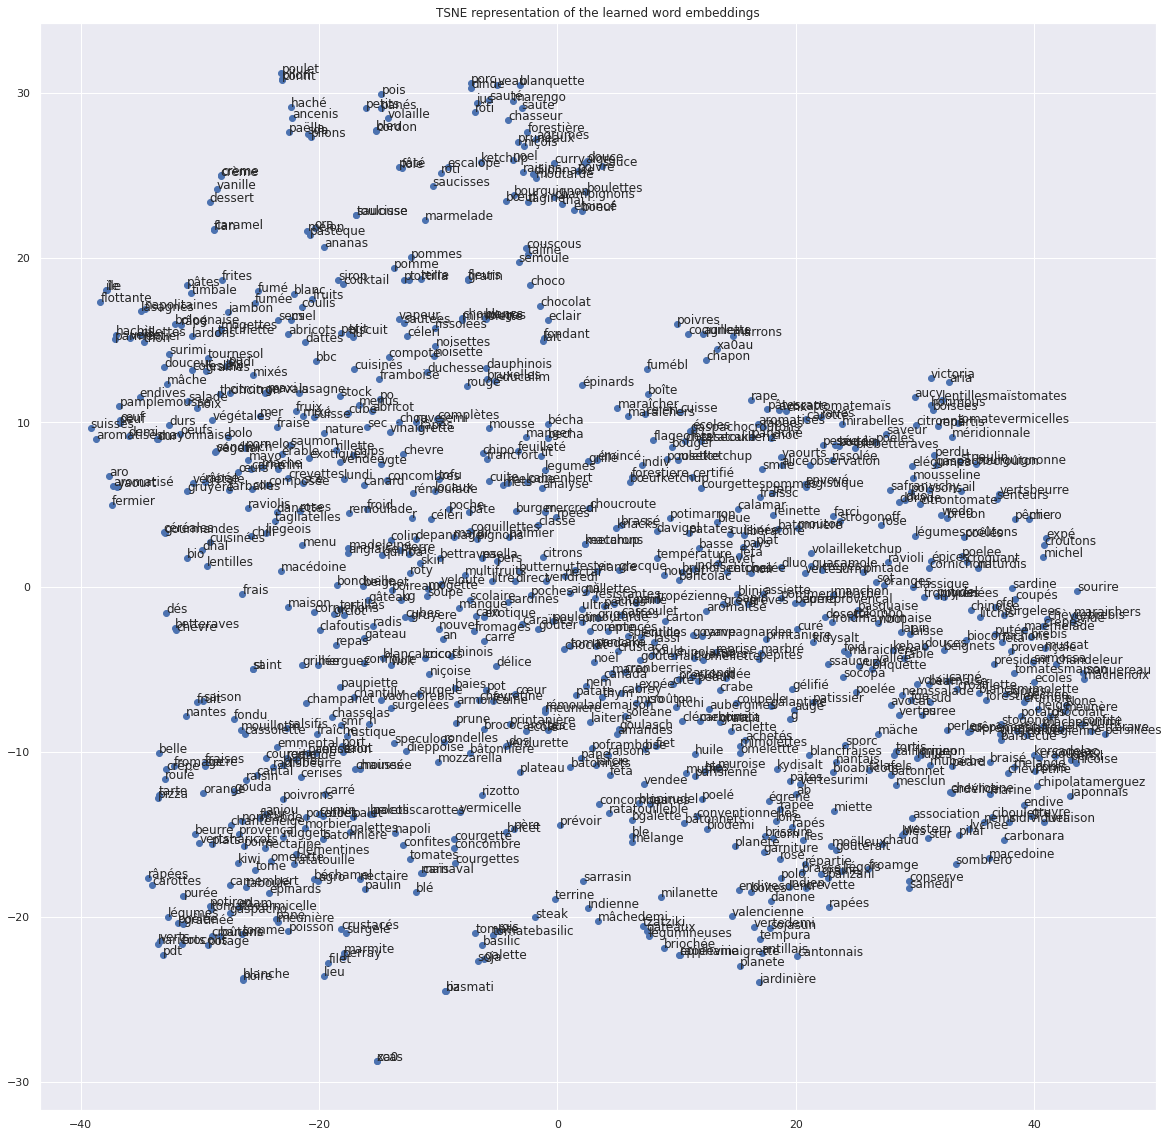

In [724]:
df = pd.DataFrame(X_tsne, index=vocab, columns=['x', 'y'])

plt.rcParams["figure.figsize"] = (20, 20)
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.title('TSNE representation of the learned word embeddings')
ax.scatter(df['x'], df['y']);

for word, pos in df.iterrows():
    ax.annotate(word, pos)

In [725]:
import numpy as np

# create a list of lists
WE = np.array(menu2vec).tolist()

# WE generated features
WE = pd.DataFrame(WE, index=temp_df.index, columns=[
                  'vec_1', 'vec_2', 'vec_3', 'vec_4', 'vec_5', 'vec_6',
                  'vec_7', 'vec_8', 'vec_9', 'vec_10', 'vec_11', 'vec_12', 'vec_13', 'vec_14', 'vec_15', 'vec_16', 'vec_17', 'vec_18', 'vec_19', 'vec_20', 'vec_21', 'vec_22', 'vec_23', 'vec_24', 'vec_25', 'vec_26',
                  'vec_27', 'vec_28', 'vec_29', 'vec_30', 'vec_31', 'vec_32','vec_33', 'vec_34', 'vec_35', 'vec_36', 'vec_37', 'vec_38',
                   'vec_39', 'vec_40', 'vec_41', 'vec_42', 'vec_43', 'vec_44', 'vec_45', 'vec_46', 'vec_47', 'vec_48', 'vec_49', 'vec_50', 'vec_51', 'vec_52', 'vec_53', 'vec_54', 'vec_55', 'vec_56', 'vec_57',
                   'vec_58', 'vec_59', 'vec_60', 'vec_61', 'vec_62', 'vec_63', 'vec_64'])

## Intégration des features NLP

Ici l'intégration des features au dataset principal se fera technique après technique afin de savoir laquelle à un impact réelle sur le résultat. Et pour chaque technique, les hyperparamètres seront modifiés.

Après expériences itératives : 
- BoW features dégradent le modèle quelque soit le nombre retenu
- Idem pour les LDA features
- WE semble plus prometteur mais demande plus de puissance de calcul


In [27]:
# intégration des features BOW
data.reset_index(level=0,inplace=True)
data = pd.merge(data, BoW, on='date', how='left')
data.head()

# intégration des features Topics
data = pd.merge(data, Lda_Topics, on='date', how='left')
data.head()

# intégration des features WE
# data = pd.merge(data, WE, on='date', how='left')
# data.head()

,index,date,prevision,reel,site_type,cantine_nom,annee_scolaire,effectif,quartier_detail,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,plats,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve,upper_outlier,lower_outlier,year,is_month_start,is_month_end,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,quarter_sin,quarter_cos,week_sin,week_cos,week_of_month_sin,week_of_month_cos,week,freq_predicted_%,freq_reel_%,freq_predicted_%_std,freq_reel_%_std,site_type_cantine_nom,site_type_annee_scolaire,site_type_quartier_detail,cantine_nom_annee_scolaire,cantine_nom_quartier_detail,annee_scolaire_quartier_detail,is_green,is_bio,is_fries,is_fish,bio,blanc,carottes,choux,creme,dinde,fromage,legumes,poisson,pomme,pommes,poulet,roti,salade,sauce,verte,yaourt,lda1,lda2,lda3,lda4,lda5,lda6,lda7,lda8,lda9,lda10
0,0,2011-01-03,5.802882e+18,13.490738,M/E,FRANCOISE DOLTO,2010-2011,191,Nantes Nord,3143.0,3208.0,3333.0,1.5795,47.2652,hachis parmentier pamplemousse salade verte fl...,17.706184,0.0,13.102797,0.0,1.48242,0.0,11.111887,0.0,33.195379,0.0,6.938084,0.0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,0.700127,0.056560,0.011723,0.001231,M/E_FRANCOISE DOLTO,M/E_2010-2011,M/E_Nantes Nord,FRANCOISE DOLTO_2010-2011,FRANCOISE DOLTO_Nantes Nord,2010-2011_Nantes Nord,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.025,0.025,0.025,0.025,0.025,0.774993,0.025001,0.025002,0.025003,0.025
1,1,2011-01-03,1.129510e+16,9.643651,E,CHENE D'ARON E,2015-2016,149,Centre ville,4200.0,4430.0,4376.0,1.5609,47.2122,hachis parmentier pamplemousse salade verte fl...,17.706184,0.0,13.102797,0.0,1.48242,0.0,11.111887,0.0,33.195379,0.0,6.938084,0.0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,0.793020,0.067778,0.067453,0.005213,E_CHENE D'ARON E,E_2015-2016,E_Centre ville,CHENE D'ARON E_2015-2016,CHENE D'ARON E_Centre ville,2015-2016_Centre ville,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.025,0.025,0.025,0.025,0.025,0.774993,0.025001,0.025002,0.025003,0.025
2,2,2011-01-03,4.400427e+19,15.524175,E,ANATOLE DE MONZIE,2014-2015,124,Ile de Nantes,3207.0,3089.0,4189.0,1.5418,47.2029,hachis parmentier pamplemousse salade verte fl...,17.706184,0.0,13.102797,0.0,1.48242,0.0,11.111887,0.0,33.195379,0.0,6.938084,0.0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,2.125000,0.128072,0.062641,0.001994,E_ANATOLE DE MONZIE,E_2014-2015,E_Ile de Nantes,ANATOLE DE MONZIE_2014-2015,ANATOLE DE MONZIE_Ile de Nantes,2014-2015_Ile de Nantes,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.025,0.025,0.025,0.025,0.025,0.774993,0.025001,0.025002,0.025003,0.025
3,3,2011-01-03,3.385841e+18,13.564660,M/E,ANDRE LERMITE/LAMORICIERE,2015-2016,334,None,NaN,NaN,NaN,NaN,NaN,hachis parmentier pamplemousse salade verte fl...,17.706184,0.0,13.102797,0.0,1.48242,0.0,11.111887,0.0,33.195379,0.0,6.938084,0.0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.571268,0.820763,0.0,1.0,0.052923,0.998599,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,0.407139,0.034173,0.016535,0.000851,M/E_ANDRE LERMITE/LAMORICIERE,M/E_2015-2016,M/E_None,ANDRE LERMITE/LAMORICIERE_2015-2016,ANDRE LERMITE/LAMORICIERE_None,2015-2016_None,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0.025,0.025,0.025,0.025,0.025,0.774993,0.025001,0.025002,0.025003,0.025
4,4,2011-01-03,4.988908e+19,15.066519,M,GASTON SERPETTE M,2017-2018,116,Hauts Pavés - Saint Félix,4131.0,3741.0,4792.0,1.5765,47.2263,hachis parmentier pamplemousse salade verte fl...,17.706184,0.0,13.102797,0.0,1.48242,0.0,11.111887,0.0,33.19537

## Splitting sets

In [28]:
data.drop(["plats"], axis=1, inplace=True)

def timeseries_train_test_split(data, split_date):
    """
        Perform train-test split with respect to time series structure
    """
    
    split_date = pd.to_datetime(split_date)

    # create train test partition
    X_train = data.loc[data['date'] < split_date]
    X_test = data.loc[data['date'] >= split_date]
    
    X_train.set_index('date', inplace=True) 
    X_test.set_index('date', inplace=True)
    
    return X_train, X_test

X_train, X_test = timeseries_train_test_split(data, '2018-09-03')

## Ajouts des features lag

Du notebook data analysis, nous testons avec les lags features de lag 10 à lag 30

In [29]:
for i in range(10, 101):
    X_train["lag_{}".format(i)] = X_train.reel.shift(i)
    X_test["lag_{}".format(i)] = X_test.reel.shift(i)

/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


## Imputing time series missing values

In [30]:
na_feats = [var for var in data.columns if data[var].isnull().sum() > 0]
data[na_feats].isnull().mean().sort_values(ascending=False)

prix_moyen_m2_maison              0.132003
quartier_detail                   0.132003
prix_quartier_detail_m2_appart    0.132003
prix_moyen_m2_appartement         0.132003
latitude                          0.132003
longitude                         0.132003
lda10                             0.063389
lda8                              0.063389
lda7                              0.063389
lda6                              0.063389
lda5                              0.063389
lda4                              0.063389
lda3                              0.063389
lda2                              0.063389
lda1                              0.063389
lda9                              0.063389
prevision                         0.013506
reel                              0.011837
freq_reel_%_std                   0.001863
freq_predicted_%_std              0.001863
freq_predicted_%                  0.001327
freq_reel_%                       0.001327
dtype: float64

In [31]:
# a good way to impute missing data in a time serie context is interpolation with time method

for col in list(X_train.cantine_nom.unique()):
    X_train.loc[X_train['cantine_nom'] == col, 'reel'] = X_train.loc[X_train['cantine_nom'] == col, 'reel'].interpolate(method='time')
    X_train.loc[X_train['cantine_nom'] == col, 'prevision'] = X_train.loc[X_train['cantine_nom'] == col, 'prevision'].interpolate(method='time')   
    X_test.loc[X_test['cantine_nom'] == col, 'reel'] = X_test.loc[X_test['cantine_nom'] == col, 'reel'].interpolate(method='time')
    X_test.loc[X_test['cantine_nom'] == col, 'prevision'] = X_test.loc[X_test['cantine_nom'] == col, 'prevision'].interpolate(method='time')

# X_train = X_train.dropna(axis=0, subset=['prevision', 'reel'])
# X_test = X_test.dropna(axis=0, subset=['prevision', 'reel'])
  

/home/quentin/.local/lib/python3.6/site-packages/pandas/core/indexing.py:1743: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [32]:
# add binary missing indicator for prevision and reel
# X_train['prevision_na'] = np.where(X_train['prevision'].isnull(), 1, 0)
# X_test['prevision_na'] = np.where(X_test['prevision'].isnull(), 1, 0)

# filling the missed ones with the median
for col in list(X_train.cantine_nom.unique()):
    med_p = X_train.loc[X_train['cantine_nom'] == col, 'prevision'].median()
    X_train.loc[X_train['cantine_nom'] == col,
                'prevision'] = X_train.loc[X_train['cantine_nom'] == col, 'prevision'].fillna(med_p)
    X_test.loc[X_test['cantine_nom'] == col,
               'prevision'] = X_test.loc[X_test['cantine_nom'] == col, 'prevision'].fillna(med_p)

### Imputing remaing missing values  

In [33]:
# continuous with the median
cols_to_impute = ['prix_quartier_detail_m2_appart', 'prix_moyen_m2_appartement',
                  'prix_moyen_m2_maison', 'longitude', 'latitude', 'freq_predicted_%', 'freq_reel_%',
                  'freq_predicted_%_std', 'freq_reel_%_std', 'lda1', 'lda2', 'lda3', 'lda4', 'lda5', 'lda6', 'lda7', 'lda8', 'lda9', 'lda10']

for col in cols_to_impute:
    median=X_train[col].median()
    X_train[col]=X_train[col].fillna(median)
    X_test[col]=X_test[col].fillna(median)

# categ with string missing (in case the fact it's missing as any meaning)
X_train['quartier_detail']=X_train['quartier_detail'].fillna('missing')
X_test['quartier_detail']=X_test['quartier_detail'].fillna('missing')

X_train.dropna(inplace = True)
X_test.dropna(inplace = True)

/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/quentin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

In [34]:
X_test_ = X_test.copy()

## Encoding categorical features

In [35]:
y_train = X_train.reel
X_train = X_train.drop(['reel'], axis=1)
y_test = X_test.reel
X_test = X_test.drop(['reel'], axis=1)

In [36]:
import category_encoders as ce

feature_list = ['site_type', 'cantine_nom', 'annee_scolaire', 'quartier_detail', 'site_type_cantine_nom', 'site_type_annee_scolaire',
                'site_type_quartier_detail', 'cantine_nom_annee_scolaire', 'cantine_nom_quartier_detail', 'annee_scolaire_quartier_detail']
TE_encoder = ce.target_encoder.TargetEncoder()

X_train[feature_list] = TE_encoder.fit_transform(
    X_train[feature_list], y_train, smoothing=10)
X_test[feature_list] = TE_encoder.transform(X_test[feature_list])

/home/quentin/.local/lib/python3.6/site-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [37]:
X_train.drop('index', axis=1, inplace=True)
X_train.head()

,prevision,site_type,cantine_nom,annee_scolaire,effectif,quartier_detail,prix_quartier_detail_m2_appart,prix_moyen_m2_appartement,prix_moyen_m2_maison,longitude,latitude,vacances_dans,depuis_vacances,ferie_dans,depuis_ferie,chretiennes_dans,depuis_chretiennes,juives_dans,depuis_juives,ramadan_dans,depuis_ramadan,musulmanes_dans,depuis_musulmanes,chretiennes,juives,ramadan,musulmanes,greve,upper_outlier,lower_outlier,year,is_month_start,is_month_end,month_sin,month_cos,day_sin,day_cos,day_of_week_sin,day_of_week_cos,day_of_year_sin,day_of_year_cos,quarter_sin,quarter_cos,week_sin,week_cos,week_of_month_sin,week_of_month_cos,week,freq_predicted_%,freq_reel_%,freq_predicted_%_std,freq_reel_%_std,site_type_cantine_nom,site_type_annee_scolaire,site_type_quartier_detail,cantine_nom_annee_scolaire,cantine_nom_quartier_detail,annee_scolaire_quartier_detail,is_green,is_bio,is_fries,is_fish,bio,blanc,carottes,choux,creme,dinde,fromage,legumes,poisson,pomme,pommes,poulet,roti,salade,sauce,verte,yaourt,lda1,lda2,lda3,lda4,lda5,lda6,lda7,lda8,lda9,lda10,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2011-01-04,4.669516e+15,12.017978,12.338743,11.689633,122,11.399948,3664.0,3103.0,4034.0,1.5938,47.2284,17.487836,0.0,13.050113,0.0,1.158419,0.0,11.043635,0.0,33.103392,0.0,6.868517,0.0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.724793,0.688967,1.0,6.123234e-17,0.070539,0.997509,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,0.740598,0.072579,0.015523,0.001499,12.338743,11.730638,11.399948,8.791378,12.338743,10.306358,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.020003,0.020007,0.020004,0.819983,0.02,0.02,0.02,0.02,0.020003,0.020001,15.652476,11.401754,13.856406,9.643651,7.745967,11.180340,10.344080,11.224972,9.899495,9.695360,16.340135,11.661904,10.246951,13.379088,16.733201,16.031220,14.142136,15.588457,15.198684,9.110434,9.848858,10.344080,18.708287,10.630146,7.141428,15.811388,12.767145,11.618950,14.212670,9.327379,11.445523,10.908712,10.770330,9.643651,14.247807,10.488088,8.246211,7.000000,8.774964,11.000000,12.767145,11.575837,11.445523,9.486833,14.106736,8.000000,13.747727,15.297059,10.535654,7.810250,10.535654,12.489996,13.304135,10.630146,8.774964,10.723805,9.273618,8.306624,16.124515,15.459625,10.099505,11.135529,7.000000,10.000000,15.524175,9.949874,13.711309,8.944272,7.549834,11.313708,10.099505,10.677078,9.327379,9.797959,15.811388,16.340135,9.797959,15.459625,6.928203,10.344080,17.549929,12.369317,9.380832,13.341664,9.327379,14.142136,15.066519,13.564660,15.524175,9.643651,13.490738
2011-01-04,1.841713e+16,12.183676,12.405248,10.906539,101,12.426872,3207.0,3020.0,4189.0,1.5390,47.2030,17.487836,0.0,13.050113,0.0,1.158419,0.0,11.043635,0.0,33.103392,0.0,6.868517,0.0,0,0,0,0,0,False,False,2011,0,0,0.5,0.866025,0.724793,0.688967,1.0,6.123234e-17,0.070539,0.997509,1.0,6.123234e-17,0.122888,0.992421,0.951057,0.309017,1,1.308504,0.106201,0.125267,0.006445,12.405248,11.313435,11.909241,10.657183,12.405248,9.875429,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.020003,0.020007,0.020004,0.819983,0.02,0.02,0.02,0.02,0.020003,0.020001,9.746794,15.652476,11.401754,13.856406,9.643651,7.745967,11.180340,10.344080,11.224972,9.899495,9.695360,16.340135,11.661904,10.246951,13.379

In [520]:
# X_train = X_train[['prevision', 'longitude', 'latitude', 'depuis_vacances', 'ferie_dans', 'depuis_juives', 'ramadan_dans', 'depuis_ramadan', 'day_of_week_sin', 'day_of_week_cos', 'day_of_year_cos', 'freq_predicted_%', 'freq_reel_%', 'freq_predicted_%_std', 'freq_reel_%_std', 'cantine_nom_annee_scolaire', 'annee_scolaire_quartier_detail', 'poisson']]
# X_test = X_test[['prevision', 'longitude', 'latitude', 'depuis_vacances', 'ferie_dans', 'depuis_juives', 'ramadan_dans', 'depuis_ramadan', 'day_of_week_sin', 'day_of_week_cos', 'day_of_year_cos', 'freq_predicted_%', 'freq_reel_%', 'freq_predicted_%_std', 'freq_reel_%_std', 'cantine_nom_annee_scolaire', 'annee_scolaire_quartier_detail', 'poisson']]

time: 451 µs (started: 2021-06-16 23:20:54 +02:00)


In [38]:
# usefull for later use
column_names = X_train.columns
cantines = X_test_[['cantine_nom', 'prevision']]

## Feature selection

Maintenant que nous avons dérivés une multitude de features potentiellement informatives grâce à l'EDA, nous nous retrouvons avec un dataset bien trop fourni. Il y a un risque important d'overfitting. C'est le moment d'opérer une sélection de features. Pour cela, nous utilisons l'aglorithme Boruta, qui est pour la plupart des datasets le meilleur outil actuel.

In [522]:
X_train.shape

(67148, 171)

time: 10.5 ms (started: 2021-06-16 23:20:55 +02:00)


In [523]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler

#scale matrices
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

# initialize Boruta
forest = RandomForestRegressor(
    n_jobs=-1
)

boruta = BorutaPy(
    estimator=forest,
    n_estimators='auto',
    max_iter=30
)

boruta.fit(X_train, y_train.values)

BorutaPy(estimator=RandomForestRegressor(n_estimators=104, n_jobs=-1,
                                         random_state=RandomState(MT19937) at 0x7FCD0CFA7EB8),
         max_iter=30, n_estimators='auto',
         random_state=RandomState(MT19937) at 0x7FCD0CFA7EB8)

time: 1h 59min 3s (started: 2021-06-16 23:20:55 +02:00)


In [1]:
# # print results
# green_area = column_names[boruta.support_].to_list()
# blue_area = column_names[boruta.support_weak_].to_list()
# print('features in the green area:', green_area)
# print('features in the blue area:', blue_area)

In [2]:
# keep only selected features by Boruta

X_train = X_train[['prevision', 'cantine_nom', 'annee_scolaire', 'effectif',
       'quartier_detail', 'prix_quartier_detail_m2_appart',
       'prix_moyen_m2_appartement', 'prix_moyen_m2_maison', 'longitude',
       'latitude', 'depuis_vacances', 'depuis_ferie', 'depuis_juives',
       'ramadan_dans', 'depuis_ramadan', 'year', 'day_of_week_sin',
       'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'freq_reel_%',
       'freq_reel_%_std']]

X_test = X_test[['prevision', 'cantine_nom', 'annee_scolaire', 'effectif',
       'quartier_detail', 'prix_quartier_detail_m2_appart',
       'prix_moyen_m2_appartement', 'prix_moyen_m2_maison', 'longitude',
       'latitude', 'depuis_vacances', 'depuis_ferie', 'depuis_juives',
       'ramadan_dans', 'depuis_ramadan', 'year', 'day_of_week_sin',
       'day_of_year_sin', 'day_of_year_cos', 'week_sin', 'freq_reel_%',
       'freq_reel_%_std']]

In [3]:
X_train.to_csv('../data/train.csv', index=False)
X_test.to_csv('../data/test.csv', index=False)